<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

# Car price prediction

In [712]:
# Import all necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import re
import os

import datetime
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import pdb
import ast, json

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [713]:
# print all columns in row
pd.set_option("display.max_columns", None)

In [714]:
!pip freeze > requirements.txt
RANDOM_SEED = 42

### Kaggle

In [715]:
# we will look at both parsed data: manually prepared and ready parsed on 09.09.2020
DIR_TRAIN_ready  = '../input/ready-all-auto-ru-09-09-2020/'
DIR_TRAIN = '../input/parsed-data/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
files = !ls '../input/parsed-data/'

### Locally

In [716]:
DIR_TRAIN_ready  = './input/'
DIR_TRAIN = './input/'
DIR_TEST   = './input/'
files = [x for x in os.listdir('./input/') if x.startswith('df')]
print(files)

['df_parsed_audi.csv', 'df_parsed_bmw.csv', 'df_parsed_honda.csv', 'df_parsed_infiniti.csv', 'df_parsed_lexus.csv', 'df_parsed_mercedes_mercedes.csv', 'df_parsed_mitsubishi.csv', 'df_parsed_nissan.csv', 'df_parsed_skoda.csv', 'df_parsed_toyota.csv', 'df_parsed_volkswagen.csv', 'df_parsed_volvo.csv']


## Functions

In [717]:
# MAPE metric
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Calculating outliers
def outliers(data, col):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l = perc25 - 1.5*IQR
    r = perc75 + 1.5*IQR
    print("For {0} IQR: {1}, \n".format(col, IQR),
          "Outliers boundaries: [{0}, {1}].".format(l, r))
    print('Total {} outliers\n'.format(
        data[data[col] > r][col].count() + data[data[col] < l][col].count()),
         '{} left outliers \n'.format(data[data[col] < l][col].count()),
         '{} right outliers \n'.format(data[data[col] > r][col].count())
         )

# Building a boxplot and  histogram for column
def get_hist_box(df, col):
    # build a histogram
    df[col].value_counts(ascending=True).plot.barh()
    
    # build a boxplot
    fig, ax = plt.subplots(figsize = (15, 10))
    sns.boxplot(x = col, y = 'price_log',data=df)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for {}'.format(col))
    plt.show()
    
# get color names in ready df
def color(row):
    #pdb.set_trace()  
    if row['Комплектация'] != "{'id': '0'}":
        try:
            val = ast.literal_eval(row['Комплектация'])['vendor_colors'][0]['stock_color']['name_ru']
            #val_1 = ast.literal_eval(row['Комплектация'])['vendor_colors'][0]['stock_color']['hex_code']
        except KeyError:
            val = 'None'
    else: 
        val = 'None'
    return val

# get complectation_dict for train_ready data
def compl(row,col):
    #pdb.set_trace()  
    # for one row testing
    #if ((row[col] != "{'id': '0'}") & pd.notnull(row[col])).all():
    if ((row[col] != "{'id': '0'}") & pd.notnull(row[col])):
    #if pd.notnull(row[col]):
        try:
            val = ast.literal_eval(row[col])['available_options']
            
        except ValueError:
            val = json.loads(row[col])['available_options']
        except KeyError:
            val = np.nan
    else: 
        val = np.nan
    return val

# format equipment_dict
def equip(row):
    #pdb.set_trace()  
    if pd.notnull(row['equipment_dict']):
        try:
            d = json.loads(row['equipment_dict'])
        except :
            d = ast.literal_eval(row['equipment_dict'])
        val = [k for k, v in d.items() if v==True]
    else: 
        val = np.nan
    
    return val

# bind complectation & equipment dict together in one list
def equip_compl(row):
    #pdb.set_trace()  
    if isinstance(row['equipment'], float):
        if isinstance(row['complectation_dict'], float):
            val = np.nan
            
        else:
            val = row['complectation_dict']
    elif isinstance(row['complectation_dict'], float): 
        val = row['equipment']
    else:
        try:
            val = list(set(row['equipment']+ row['complectation_dict']))
        except:
            val = list(set(row['equipment']+ ast.literal_eval(row['complectation_dict'])))
    return val

# format engine displacement
def eng_displ(row):
    # pdb.set_trace()  
    if ((row['train']==1) & (row['new_data']==0) & (row['fuelType']!='электро')):
        extracted_value = re.findall('\d\.\d', str(row['name']))
        if extracted_value:
            return float(extracted_value[0])
    elif row['fuelType']=='электро':
        return 0
    else:
        try:
            val = str(row['engineDisplacement']).split()[0]
            return float(val)
        except:
            return np.nan
        
# format engine power
def eng_power(row):
    # pdb.set_trace()  
    if type(row['enginePower']) == str:
        extracted_value = float(str(row['enginePower']).split()[0])
        return extracted_value
    else:
        try:
            val = row['enginePower']
            return float(val)
        except:
            return np.nan
        
def fill_st_wheel(brand, model, right_wheel_dict):
    try:
        if model in right_wheel_dict[brand]:
            return 'right'
        else:
            return 'left'
    except:
        return 'left'

In [718]:
# read all df
# we used ready df from 2020 +
# our parsed data from 2021
train_r = pd.read_csv(DIR_TRAIN_ready+'all_auto_ru_09_09_2020.csv') 

train_parsed = pd.DataFrame(columns = ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'views', 'date_added',
       'region', 'price'])  
for file in files:
    model = pd.read_csv(DIR_TRAIN+file)
    #pdb.set_trace()  
    train_parsed = pd.concat([train_parsed,model], ignore_index=True)
    
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [719]:
train_parsed.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,views,date_added,region,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,NaN,Автомобиль в отличном состоянии На фото именно...,1.0 LTR,110 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,98000.0,2017.0,NaN,Rapid,Skoda Rapid I Рестайлинг,5.0,1.634236e+09,RUB,2018.0,1.105436e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK MECHANICAL 1.0,механическая,EUROPEAN,1 владелец,3 года и 2 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1069.0,7 октября,в Москве,1030000.0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серебристый,NaN,2 собственника по ПТС эксплуатировался одним ч...,1.4 LTR,140 N12,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,86000.0,2013.0,NaN,Octavia,Skoda Octavia III (A7),5.0,1.634236e+09,RUB,2015.0,1.105548e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK ROBOT 1.4,роботизированная,EUROPEAN,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,464.0,8 октября,в Екатеринбурге,1130000.0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,Я второй собственник вписан в ПТС с августа 20...,1.2 LTR,105 N12,"{'cruise-control': True, 'engine-proof': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,179000.0,2008.0,NaN,Octavia,Skoda Octavia II (A5) Рестайлинг,5.0,1.634236e+09,RUB,2011.0,1.105604e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,2 владельца,2 года и 2 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,163.0,13 октября,в Москве,800000.0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,Авто в отлично состайни из минусов надо делать...,2.0 LTR,115 N12,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,514000.0,1996.0,NaN,Octavia,Skoda Octavia I (A4),5.0,1.634236e+09,RUB,1999.0,1.105094e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK MECHANICAL 2.0,механическая,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,918.0,11 октября,в Москве,150000.0
4,лифтбек,SKODA,https://auto.ru/cars/new/group/skoda/rapid/217...,белый,NaN,Автомир Богемия Дмитровка Официальный дилер S...,1.6 LTR,110 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,NaN,2020.0,NaN,NaN,Skoda Rapid II,5.0,1.634236e+09,RUB,2021.0,1.105618e+09,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1530000.0


In [720]:
train_r.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [721]:
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [722]:
train_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138775 entries, 0 to 138774
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              138708 non-null  object 
 1   brand                 138710 non-null  object 
 2   car_url               138748 non-null  object 
 3   color                 138710 non-null  object 
 4   complectation_dict    88310 non-null   object 
 5   description           138710 non-null  object 
 6   engineDisplacement    138710 non-null  object 
 7   enginePower           138710 non-null  object 
 8   equipment_dict        138710 non-null  object 
 9   fuelType              138708 non-null  object 
 10  image                 138722 non-null  object 
 11  mileage               108354 non-null  float64
 12  modelDate             138708 non-null  float64
 13  model_info            0 non-null       float64
 14  model_name            108354 non-null  object 
 15  

In [723]:
train_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

We can remove 'hidden' , 'Состояние' columns as trey are empty, it seems that start date is the same as date_added

In [724]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

So we have empty train_parsed["model_info"] column, and according to the test['model_info']  it contains the information which is presented in other columns. 
We will remove it

In [725]:
train_parsed.drop(['model_info'], axis = 1, inplace=True)
test.drop(['model_info'], axis = 1, inplace=True)

In [726]:
# check what columns are in train_parsed and not presented in test
  
list(set(train_parsed.columns) - set(test.columns))        

['date_added', 'region', 'price', 'views']

In [727]:
# check what columns are in train_ready and not in train_parsed
list(set(train_r.columns) - set(train_parsed.columns))        

['model', 'Комплектация', 'start_date', 'hidden']

In [728]:
# check what columns are in train_parsed and not presented in train_ready
list(set(train_parsed.columns) - set(train_r.columns))        

['equipment_dict',
 'model_name',
 'region',
 'complectation_dict',
 'date_added',
 'image',
 'priceCurrency',
 'vendor',
 'sell_id',
 'car_url',
 'super_gen',
 'parsing_unixtime',
 'views']

In [729]:
# check what columns are in test and not presented in train_ready
list(set(test.columns) - set(train_r.columns))        

['equipment_dict',
 'model_name',
 'complectation_dict',
 'image',
 'priceCurrency',
 'vendor',
 'sell_id',
 'car_url',
 'super_gen',
 'parsing_unixtime']

In [730]:
print(test.priceCurrency.unique())
print(train_parsed.priceCurrency.unique())

['RUB']
['RUB' 'RUR' nan]


According to this https://fingeniy.com/810-i-643-rur-i-rub-kakoj-kod-valyuty-rublya/ 'RUB' & 'RUR' is the same so we have only one currency in price and could remove this column, but will leave it in order to look at it with price column!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!11

According to the datasets, we could remove car_url, image columns. We can also add 'vendor column to the parsed data

In [731]:
model = sorted(train_r.model.unique())
model

['02',
 '100',
 '1007',
 '100NX',
 '100_SERIES',
 '106',
 '107',
 '120',
 '121',
 '140',
 '180SX',
 '19',
 '190_SL',
 '1ER',
 '2',
 '20',
 '200',
 '2008',
 '200SX',
 '203',
 '205',
 '206',
 '207',
 '208',
 '240_SERIES',
 '280ZX',
 '2ACTIVETOURER',
 '2ER',
 '2GRANDTOURER',
 '3',
 '3008',
 '300C',
 '300M',
 '300_LETTER_SERIES',
 '301',
 '306',
 '307',
 '308',
 '321',
 '323',
 '326',
 '340',
 '350Z',
 '356',
 '3ER',
 '3MPS',
 '4',
 '4007',
 '4008',
 '405',
 '406',
 '407',
 '408',
 '440',
 '460',
 '4RUNNER',
 '5',
 '5008',
 '508',
 '5ER',
 '6',
 '605',
 '607',
 '626',
 '6ER',
 '6_MPS',
 '740',
 '760',
 '7ER',
 '80',
 '806',
 '850',
 '8ER',
 '90',
 '911',
 '911_GT3',
 '918_SPYDER',
 '920',
 '924',
 '928',
 '940',
 '944',
 '960',
 '968',
 'A1',
 'A2',
 'A3',
 'A4',
 'A4_ALLROAD',
 'A5',
 'A6',
 'A7',
 'A8',
 'ACCENT',
 'ACCORD',
 'ACTY',
 'ACTYON',
 'ACTYON_SPORT',
 'AD',
 'ADMIRAL',
 'AERIO',
 'AEROSTAR',
 'AGILA',
 'AIRTREK',
 'AIRWAVE',
 'ALERO',
 'ALLEX',
 'ALLROAD',
 'ALMERA',
 'ALMERA_

it seems that model is the same as model_name

In [732]:
# add vendor column to the ready parsed data
ven_dict = pd.Series(test.vendor.values,index=test.brand).to_dict()
train_r['vendor'] = train_r.brand.map(ven_dict)

train_r.rename(columns= {'start_date':'date_added', 'model':'model_name'}, inplace=True)

In [733]:
# add date of parsing for ready data
s = '09/09/2020'
train_r['parsing_unixtime'] = int(datetime.strptime(s, "%d/%m/%Y").timestamp())

In [734]:
# add column with real color names
train_r['color_new'] = train_r.apply(color, axis=1)
col_dict = pd.Series(train_r[train_r.color_new!= 'None'].\
                     color_new.values,index=train_r[train_r.color_new!= 'None'].color).to_dict()
train_r['color_new'] = train_r['color'].map(col_dict)

# rename column with real color names 
train_r.drop('color', axis=1, inplace=True)
train_r.rename(columns= {'color_new':'color'}, inplace=True)

In [735]:
# format complectation column before binding
train_r['complectation_dict'] = train_r.apply(lambda x: compl(x,'Комплектация'), axis=1)
train_r.drop(['hidden', 'Комплектация'], axis = 1, inplace =True)


In [736]:
train_r.head()

,bodyType,brand,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,date_added,model_name,vendor,parsing_unixtime,color,complectation_dict
0,Седан,AUDI,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,100,EUROPEAN,1599598800,черный,NaN
1,Седан,AUDI,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,100,EUROPEAN,1599598800,красный,NaN
2,Универсал 5 дв.,AUDI,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,100,EUROPEAN,1599598800,синий,NaN
3,Седан,AUDI,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,100,EUROPEAN,1599598800,серебряный,NaN
4,Седан,AUDI,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,100,EUROPEAN,1599598800,черный,NaN


In [737]:
# format complectation column before binding
test['complectation_dict_new'] = test.apply(lambda x: compl(x,'complectation_dict'), axis=1)
test.drop('complectation_dict', axis = 1, inplace =True)
test.rename(columns= {'complectation_dict_new':'complectation_dict'}, inplace=True)

In [738]:
test.head()

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,complectation_dict
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"[heated-wash-system, airbag-passenger, lock, d..."
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"[heated-wash-system, airbag-passenger, lock, e..."
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN


In [739]:
# let's add the column showing whether we have train or test set to have the opportunity to combine/split them easily
train_parsed['train'] = 1
train_r['train'] = 1 
test['train'] = 0

# this column should be added to the the train datasets because it's present in the test one and is used for the submission 
train_r['sell_id'] = 0  
train_parsed['sell_id'] = 0 

# create a column showing whether the data is new or old
train_r['new_data'] = 0
train_parsed['new_data'] = 1 
test['new_data'] = 0

In [740]:
bined_df = pd.concat([test, train_r, train_parsed.drop(labels=['views', 'region'], axis=1)], ignore_index=True)
# rename russian column names
bined_df.rename(columns={'Владельцы': 'owners', 'Владение': 'ownership', 'ПТС': 'vehicle_licence',
       'Привод': 'driving_gear', 'Руль': 'steering_wheel', 'Состояние': 'condition', 'Таможня': 'customs'}, inplace=True)

bined_df.head()

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,complectation_dict,train,new_data,price,date_added
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000.0,2013.0,OCTAVIA,1.2 AMT (105 л.с.),5.0,1.603226e+09,RUB,2014.0,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,0,0,NaN,NaN
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563.0,2017.0,OCTAVIA,1.6 MT (110 л.с.),5.0,1.603226e+09,RUB,2017.0,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,0,0,NaN,NaN
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000.0,2013.0,SUPERB,DSG 1.8 AMT (152 л.с.),5.0,1.603226e+09,RUB,2014.0,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"[heated-wash-system, airbag-passenger, lock, d...",0,0,NaN,NaN
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000.0,2013.0,OCTAVIA,1.6 AT (110 л.с.),5.0,1.603226e+09,RUB,2014.0,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"[heated-wash-system, airbag-passenger, lock, e...",0,0,NaN,NaN
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536.0,2008.0,OCTAVIA,1.8 AT (152 л.с.),5.0,1.603226e+09,RUB,2012.0,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,0,0,NaN,NaN


In [741]:
# look at the data with nan in brand
bined_df[bined_df.brand.isnull()]

# remove it
bined_df.dropna(subset = ['brand'], inplace=True)

In [742]:
bined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262774 entries, 0 to 262838
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              262771 non-null  object 
 1   brand                 262774 non-null  object 
 2   car_url               173396 non-null  object 
 3   color                 262749 non-null  object 
 4   description           259520 non-null  object 
 5   engineDisplacement    262773 non-null  object 
 6   enginePower           262773 non-null  object 
 7   equipment_dict        163400 non-null  object 
 8   fuelType              262772 non-null  object 
 9   image                 173370 non-null  object 
 10  mileage               232418 non-null  float64
 11  modelDate             262771 non-null  float64
 12  model_name            232418 non-null  object 
 13  name                  262773 non-null  object 
 14  numberOfDoors         262771 non-null  float64
 15  

In [743]:
# As we had some issues with parsing
# we need to check how many records are duplicated
print(bined_df.astype(str).duplicated(keep=False).value_counts())

False    259064
True       3710
dtype: int64


In [744]:
# Remove duplicates
bined_df = bined_df.loc[bined_df.astype(str).drop_duplicates().index]

In [745]:
# Check again
print(bined_df.astype(str).duplicated(keep=False).value_counts())

False    260639
dtype: int64


## EDA

TO DO:
* check unique values for every column
* fill missing values
* drop unnecessary columns
* build histograms
* build boxplots
* build correlation plot

In [746]:
# Check the dataset shape
bined_df.shape

(260639, 35)

In [747]:
bined_df.describe()

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id,train,new_data,price
count,2.302830e+05,260636.000000,260636.000000,2.606390e+05,260639.000000,2.606390e+05,260639.000000,260639.000000,2.213140e+05
mean,1.473372e+05,2009.789250,4.533848,1.618544e+09,2011.959477,1.461625e+08,0.866919,0.532192,2.156369e+06
std,1.003069e+05,7.432079,0.663351,1.681764e+07,7.141304,3.731165e+08,0.339662,0.498964,3.263852e+06
min,0.000000e+00,1904.000000,0.000000,1.599599e+09,1904.000000,0.000000e+00,0.000000,0.000000,1.600000e+04
25%,7.600000e+04,2006.000000,4.000000,1.599599e+09,2008.000000,0.000000e+00,1.000000,0.000000,5.000000e+05
50%,1.416450e+05,2010.000000,5.000000,1.634223e+09,2012.000000,0.000000e+00,1.000000,1.000000,1.000000e+06
75%,2.000000e+05,2016.000000,5.000000,1.634268e+09,2018.000000,0.000000e+00,1.000000,1.000000,2.320000e+06
max,1.150000e+06,2021.000000,5.000000,1.634351e+09,2021.000000,1.101375e+09,1.000000,1.000000,9.900000e+07


In [748]:
# bined_df.columns

In [749]:
# Count missing values in every column
bined_df.isna().sum()

bodyType                     3
brand                        0
car_url                  87243
color                       25
description               3233
engineDisplacement           1
enginePower                  1
equipment_dict           97239
fuelType                     2
image                    87269
mileage                  30356
modelDate                    3
model_name               30356
name                         1
numberOfDoors                3
parsing_unixtime             0
priceCurrency            87243
productionDate               0
sell_id                      0
super_gen                87243
vehicleConfiguration         3
vehicleTransmission          3
vendor                   43251
owners                   42352
ownership               200509
vehicle_licence          30714
driving_gear             30359
steering_wheel           30356
condition               117600
customs                  30358
complectation_dict      137400
train                        0
new_data

### Profile report

In [750]:
# Perform quick analysis
# bined_profile = 
# pp.ProfileReport(bined_df, correlations={
#        "pearson": {"calculate": True},
#        "spearman": {"calculate": True},
#        "kendall": {"calculate": False},
#        "phi_k": {"calculate": True},
#        "cramers": {"calculate": True},
#    })
# bined_profile.to_file("bined_profile.html")

**Summary:**
* the dataset consists of 34 variables and 260660 observations
* 11.9% values are missing
* the data needs cleaning and formatting
* the report shows that we have 8 numeric, 23 categorical variables and 3 of an unsupported type (needs investigation)
* for the 'bodyType' column we need to convert values to lower register and remove extra information about doors
* we have 36 brands in the final dataset so we need to leave only 12
* 'complectation_dict' column needs to be checked for any useful data
* we can try to extract some new data from the 'description' column then drop it (if we don't have time for it, then we'll just drop it)
* 'engineDisplacement' column values need to be converted to numeric (float) values
* 'mileage' values need to be explored
* for the 'name' column we need to decide what information we can extract
* in the 'numberOfDoors' column we need to check records with 0 doors
* from the 'parsing_unixtime' column we need to extract some useful data and the drop it
* we shouldn't include 'sell_id'column into numerical columns list
* 'vehicleConfiguration' column obviously combines information from 'vehicleTransmission', 'engineDisplacement' and 'bodyType' columns
* 'vehicle_licence' column needs to be formatted to English lowercase
* 76.8% of values in the 'ownership' columns are missing, e.g. we can drop the column
* we need to format 'steering_wheel' values to English, lower register
* 'condition' column either have "не требует ремонта" value or empty, probably we should drop it
* 'customs' column probably should be dropped, too
* there's expectedly strong correlation between 'mileage', 'modelDate' and 'productionDate' variables
* 'vendor' and 'brand' variables are also strongly correlated

### Detailed feature analysis

In [751]:
# Drop unnecessary columns
bined_df.drop(['car_url', 'image'], axis = 1, inplace = True) 

In [752]:
bined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260639 entries, 0 to 262838
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              260636 non-null  object 
 1   brand                 260639 non-null  object 
 2   color                 260614 non-null  object 
 3   description           257406 non-null  object 
 4   engineDisplacement    260638 non-null  object 
 5   enginePower           260638 non-null  object 
 6   equipment_dict        163400 non-null  object 
 7   fuelType              260637 non-null  object 
 8   mileage               230283 non-null  float64
 9   modelDate             260636 non-null  float64
 10  model_name            230283 non-null  object 
 11  name                  260638 non-null  object 
 12  numberOfDoors         260636 non-null  float64
 13  parsing_unixtime      260639 non-null  float64
 14  priceCurrency         173396 non-null  object 
 15  

In [753]:
# Create feature categories lists

# numerical features
num_cols = []

# binary features
bin_cols = []

# categorical features
cat_cols = []

# other features
other = ['sell_id', 'train', 'new_data']

#### price

In [754]:
# Let's start with the target variable
bined_df.price.describe()

count    2.213140e+05
mean     2.156369e+06
std      3.263852e+06
min      1.600000e+04
25%      5.000000e+05
50%      1.000000e+06
75%      2.320000e+06
max      9.900000e+07
Name: price, dtype: float64

In [755]:
# Check empty price values for records from non test dataset
bined_df[bined_df.train == 1].price.isna().sum()

4639

In [756]:
# Drop these values because we can't teach the model with empty target value
bined_df = bined_df.drop(bined_df[(bined_df.train == 1) & (bined_df.price.isna())].index)

In [757]:
# Check the result
bined_df[bined_df.train == 1].price.isna().sum()

0

In [758]:
bined_df.loc[bined_df.new_data == 1, 'price']

124064    1030000.0
124065    1130000.0
124066     800000.0
124067     150000.0
124068    1530000.0
            ...    
262834     110000.0
262835    7160000.0
262836    1370000.0
262837    1610000.0
262838    9580000.0
Name: price, Length: 134481, dtype: float64

In [759]:
# According to https://mag.auto.ru/article/risepricescalltouchpres/ the average
# price increase is 15% for new cars and 25% for used cars
# Let's try the average percent for these two (20 %)
bined_df.loc[bined_df.new_data == 1,'price'] = bined_df.loc[bined_df.new_data == 1,'price']*0.8

In [760]:
bined_df.loc[bined_df.new_data == 1, 'price']

124064     824000.0
124065     904000.0
124066     640000.0
124067     120000.0
124068    1224000.0
            ...    
262834      88000.0
262835    5728000.0
262836    1096000.0
262837    1288000.0
262838    7664000.0
Name: price, Length: 134481, dtype: float64

<AxesSubplot:>

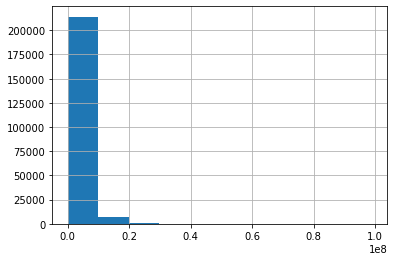

In [761]:
bined_df.price.hist()

<AxesSubplot:xlabel='price', ylabel='Density'>

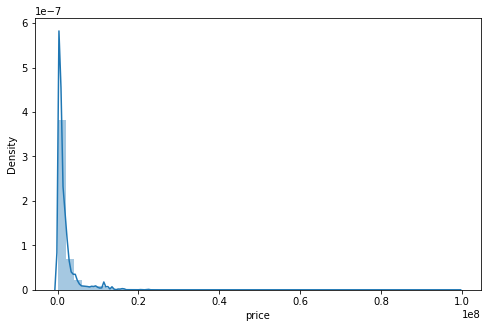

In [762]:
fig, axes = plt.subplots(1, figsize=(8, 5))
sns.distplot(bined_df['price'])

We can see that this distribution doesn't look normal. Let's take a look at the logarithm of the price.

In [763]:
bined_df['price_log'] = np.log(bined_df['price'])

In [764]:
other.append('price_log')

In [765]:
bined_df.price_log.describe()

count    221314.000000
mean         13.781053
std           1.094490
min           9.680344
25%          13.038982
50%          13.687677
75%          14.490494
max          18.410630
Name: price_log, dtype: float64

<AxesSubplot:xlabel='price_log', ylabel='Density'>

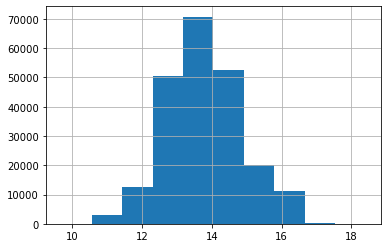

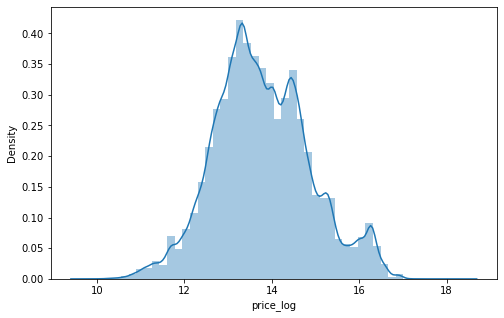

In [766]:
bined_df.price_log.hist()
fig, axes = plt.subplots(1, figsize=(8, 5))
sns.distplot(bined_df['price_log'])

Now the distribution looks much better so we'll work with 'price_log' column

In [767]:
outliers(bined_df, 'price_log')

For price_log IQR: 1.451511999431272, 
 Outliers boundaries: [10.861713769318369, 16.66776176704346].
Total 893 outliers
 444 left outliers 
 449 right outliers 



According to histograms and outliers calculation there are no abnormal price values

In [768]:
bined_df[(bined_df.train == 1) & (bined_df.price > 38000000)].price.sort_values()

121580    45000000.0
121565    48000000.0
123341    52500000.0
121571    54057400.0
121573    54057400.0
121567    54560408.0
121589    54560408.0
121563    58089720.0
121575    58089720.0
121564    59087576.0
121568    59087576.0
121560    65435792.0
121899    68500000.0
91271     99000000.0
Name: price, dtype: float64

Current highest price on auto.ru is 37 M RUR. Doesn't look like these values are outliers because we have a combined dataset for 2020-2021, so there could have been such high prices. 

#### bodyType

In [769]:
# Check the unique values for bodyType
bined_df.bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон', 'Седан', 'Универсал 5 дв.',
       'Хэтчбек 5 дв. Sportback', 'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.',
       'Кабриолет', 'Купе', 'Лифтбек Sportback', 'Лифтбек', 'Седан Long',
       'Внедорожник 5 дв.', 'Кабриолет Roadster', 'Седан 2 дв.',
       'Седан Gran Coupe', 'Компактвэн', 'Компактвэн Gran Tourer',
       'Лифтбек Gran Turismo', 'Хэтчбек 3 дв. Compact',
       'Лифтбек Gran Coupe', 'Купе-хардтоп', 'Родстер Roadster',
       'Родстер', 'Внедорожник 5 дв. ESV', 'Минивэн',
       'Пикап Двойная кабина', 'Внедорожник 3 дв.',
       'Пикап Одинарная кабина', 'Тарга', 'Пикап

In [770]:
# Transform into one word lowercase name
bined_df['bodyType'] = bined_df['bodyType'].apply(lambda x: str(x).lower().split()[0])

In [771]:
bined_df.bodyType.value_counts()

внедорожник      102613
седан             87924
хэтчбек           20501
лифтбек           19153
универсал          7957
минивэн            5471
купе               4720
компактвэн         3442
пикап              1767
купе-хардтоп        783
кабриолет           608
родстер             481
фургон              440
микровэн             73
седан-хардтоп        36
лимузин              13
тарга                11
фастбек               4
nan                   3
Name: bodyType, dtype: int64

In [772]:
# As there are 3 nan values let's try to replace them
bined_df[bined_df['bodyType'] == 'nan']

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,complectation_dict,train,new_data,price,date_added,price_log
59310,nan,HONDA,серебряный,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,NaN,универсал,400000.0,NaN,CIVIC,NaN,NaN,1.599599e+09,NaN,1989.0,0,NaN,NaN,NaN,JAPANESE,3.0,NaN,ORIGINAL,NaN,LEFT,NaN,True,NaN,1,0,120000.0,2020-04-10T16:07:57Z,11.695247
160253,nan,HONDA,пурпурный,В хорошем состоянии на ходу,LTR,undefined N12,{},NaN,260000.0,NaN,Civic,Honda Civic,NaN,1.634279e+09,RUB,1989.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",NaN,NaN,JAPANESE,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,NaN,1,1,104000.0,13 марта 2020,11.552146
261029,nan,VOLVO,коричневый,Продам VOLVO V70 универсал в отличном состояни...,LTR,undefined N12,"{'engine-proof': True, 'cruise-control': True,...",NaN,133000.0,NaN,V70,Volvo V70,NaN,1.634288e+09,RUB,2008.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",NaN,NaN,EUROPEAN,2 владельца,3 месяца,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,NaN,1,1,768000.0,9 августа,13.551545


In [773]:
type(bined_df.loc[160253]['bodyType'])

str

In [774]:
bined_df.loc[59310].bodyType

'nan'

In [775]:
# Let's fill empty values with correct ones
bined_df.bodyType.loc[59310] = 'универсал'
bined_df.bodyType.loc[160253] = 'хэтчбек'
bined_df.bodyType.loc[261029] = 'универсал'

In [776]:
bined_df[bined_df['bodyType'] == 'nan']

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,complectation_dict,train,new_data,price,date_added,price_log


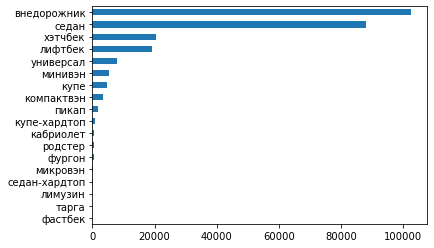

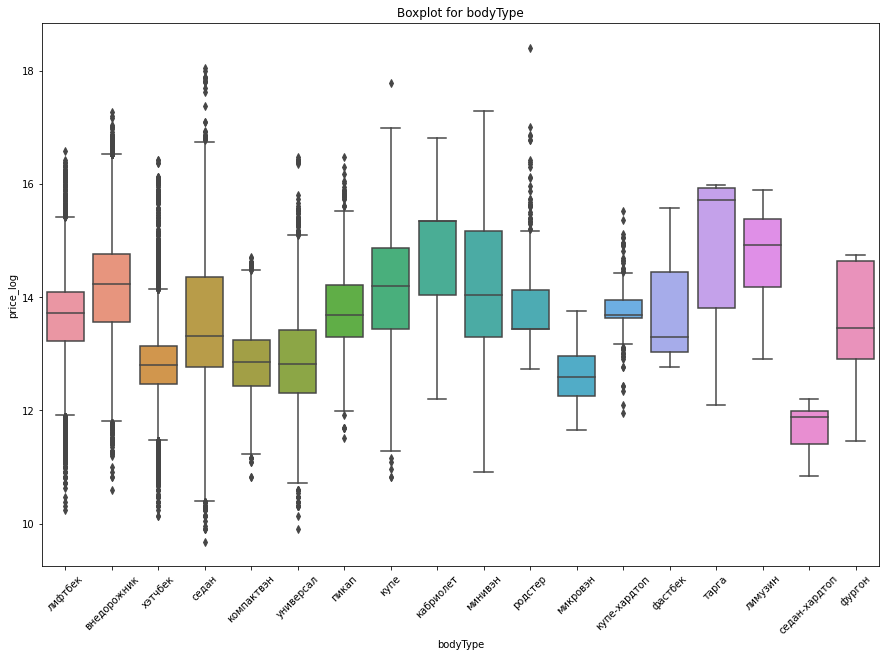

In [777]:
get_hist_box(bined_df, 'bodyType')

Here we can see that the most popular models are внедорожник, седан, хэтчбек, лифтбек. Тарга and лимузин have the highest average price. Among the most popular models body type внедорожник is the most expensive.

In [778]:
# Add this column to cat_cols
cat_cols.append('bodyType')

#### brand

In [779]:
# Check the unique values for brand
bined_df.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA',
       'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU',
       'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG'], dtype=object)

In [780]:
brands = test.brand.unique().tolist()

In [781]:
brands

['SKODA',
 'AUDI',
 'HONDA',
 'VOLVO',
 'BMW',
 'NISSAN',
 'INFINITI',
 'MERCEDES',
 'TOYOTA',
 'LEXUS',
 'VOLKSWAGEN',
 'MITSUBISHI']

In [782]:
# Delete brands that are not presented in test dataframe
bined_df = bined_df[bined_df.brand.isin(brands)]

In [783]:
bined_df.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

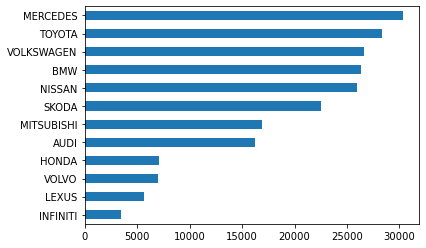

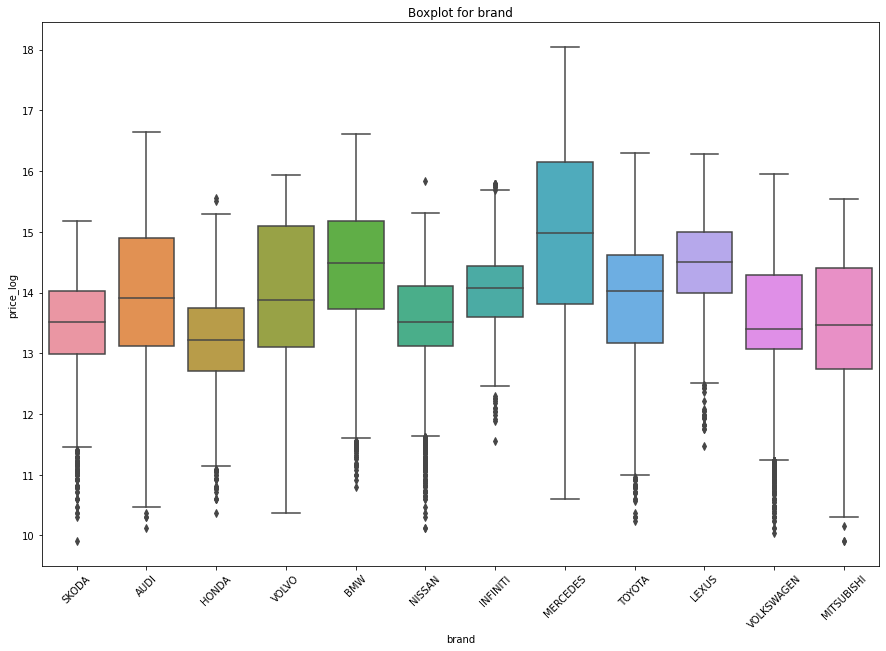

In [784]:
get_hist_box(bined_df, 'brand')

By the time of the analysis Mercedes has the highest average price and Honda has the lowest.

In [785]:
# Add this column to cat_cols
cat_cols.append('brand')

#### color

In [786]:
# Check the unique values for color
bined_df.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый',
       'черный', 'серебряный', nan], dtype=object)

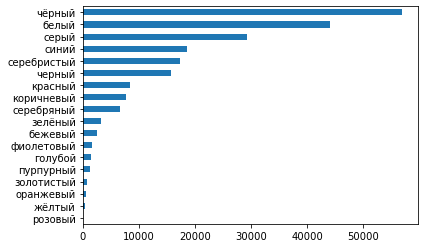

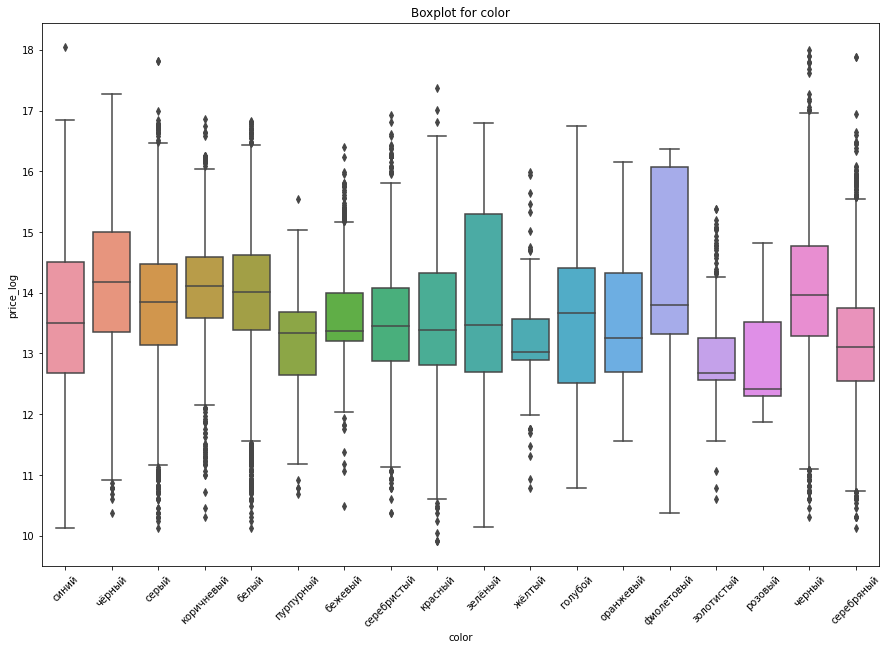

In [787]:
get_hist_box(bined_df, 'color')

The most popular color is black, black cars have the highest average price.

In [788]:
# Add this column to cat_cols
cat_cols.append('color')

#### description

In [789]:
# Let's check the values
bined_df.description[2]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

Only 1.3% of descriptions are missing, but the only way we can use this column is to try to process the text (e.g. extract some keywords). If we have enough time we'll return to this column, but by now we'll drop it.

In [790]:
bined_df.drop(['description'], axis = 1, inplace = True)

#### engineDisplacement

In [791]:
# Check unique values
bined_df.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d',
       '2.5d', '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3',
       '1.4', '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '3.0d',
       '2.7d', '16V', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55',
       '2.7', '4.2', 'S-tronic', 'Tiptronic', 'Long',

In [792]:
# format engine displacement
bined_df['engineDisplacement'] = bined_df.apply(eng_displ, axis = 1)
bined_df['engineDisplacement'] .unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, 0. , 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, nan])

In [793]:
len(bined_df['engineDisplacement'].unique())

56

There's 55 different engine modifications, let's examine top 20 of them.

In [794]:
bined_df[bined_df.engineDisplacement.isna()]

,bodyType,brand,color,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,complectation_dict,train,new_data,price,date_added,price_log
59310,универсал,HONDA,серебряный,NaN,NaN,NaN,универсал,400000.0,NaN,CIVIC,NaN,NaN,1.599599e+09,NaN,1989.0,0,NaN,NaN,NaN,JAPANESE,3.0,NaN,ORIGINAL,NaN,LEFT,NaN,True,NaN,1,0,120000.0,2020-04-10T16:07:57Z,11.695247
160253,хэтчбек,HONDA,пурпурный,NaN,undefined N12,{},NaN,260000.0,NaN,Civic,Honda Civic,NaN,1.634279e+09,RUB,1989.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",NaN,NaN,JAPANESE,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,NaN,1,1,104000.0,13 марта 2020,11.552146
261029,универсал,VOLVO,коричневый,NaN,undefined N12,"{'engine-proof': True, 'cruise-control': True,...",NaN,133000.0,NaN,V70,Volvo V70,NaN,1.634288e+09,RUB,2008.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",NaN,NaN,EUROPEAN,2 владельца,3 месяца,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,NaN,1,1,768000.0,9 августа,13.551545


We see the same records. They obviously have the bad quality, so it's better to drop there rows.

In [795]:
bined_df = bined_df[~bined_df.engineDisplacement.isna()]

In [796]:
bined_df[bined_df.engineDisplacement.isna()]

,bodyType,brand,color,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,complectation_dict,train,new_data,price,date_added,price_log


In [797]:
bined_df.engineDisplacement.describe()

count    216599.000000
mean          2.363527
std           0.908748
min           0.000000
25%           1.800000
50%           2.000000
75%           3.000000
max           6.600000
Name: engineDisplacement, dtype: float64

<AxesSubplot:>

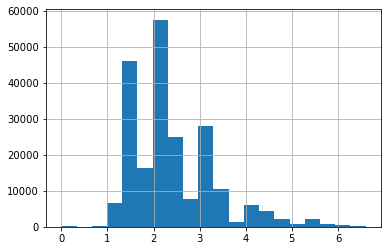

In [798]:
bined_df.engineDisplacement.hist(bins = 20)

In [799]:
bined_df.engineDisplacement.value_counts().head(20)

2.0    53142
1.6    28954
3.0    25504
2.5    16503
1.8    14633
1.4    12843
3.5     9010
2.4     8126
4.0     4941
2.9     4230
1.5     4179
1.2     3170
2.1     2102
1.3     2060
4.7     2055
3.2     2030
4.5     1912
2.7     1856
4.4     1825
2.8     1684
Name: engineDisplacement, dtype: int64

In [800]:
bined_df.engineDisplacement.value_counts(bins = 5)

(1.32, 2.64]       144677
(2.64, 3.96]        47625
(3.96, 5.28]        13423
(-0.0076, 1.32]      7326
(5.28, 6.6]          3548
Name: engineDisplacement, dtype: int64

In [801]:
bined_engD = bined_df[bined_df.engineDisplacement<3]

<AxesSubplot:xlabel='engineDisplacement', ylabel='price_log'>

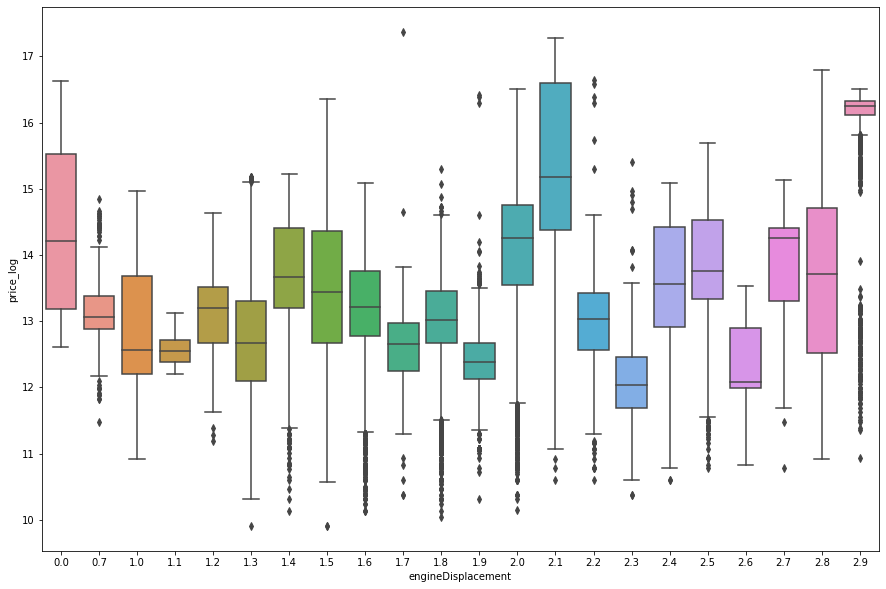

In [802]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(x = 'engineDisplacement', y = 'price_log', data=bined_engD)

In [803]:
outliers(bined_df, 'engineDisplacement')

For engineDisplacement IQR: 1.2, 
 Outliers boundaries: [2.220446049250313e-16, 4.8].
Total 4565 outliers
 347 left outliers 
 4218 right outliers 



The most popular engine volume is 2.0 LTR, but these cars have not the highest average price.

#### enginePower

In [804]:
# Check unique values
bined_df.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [805]:
bined_df['enginePower'] = bined_df.apply(eng_power, axis = 1)
sorted(bined_df['enginePower'] .unique())

[30.0,
 32.0,
 38.0,
 40.0,
 41.0,
 42.0,
 44.0,
 46.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 57.0,
 58.0,
 60.0,
 61.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 120.0,
 121.0,
 122.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 135.0,
 136.0,
 137.0,
 139.0,
 140.0,
 141.0,
 142.0,
 143.0,
 144.0,
 145.0,
 146.0,
 147.0,
 148.0,
 149.0,
 150.0,
 151.0,
 152.0,
 153.0,
 154.0,
 155.0,
 156.0,
 157.0,
 158.0,
 159.0,
 160.0,
 161.0,
 162.0,
 163.0,
 164.0,
 165.0,
 166.0,
 167.0,
 168.0,
 169.0,
 170.0,
 171.0,
 173.0,
 174.0,
 175.0,
 176.0,
 177.0,
 178.0,
 179.0,
 180.0,
 181.0,
 182.0

There is no NaN's here

<AxesSubplot:>

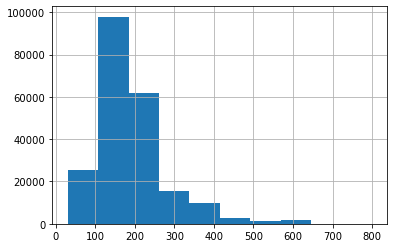

In [968]:
bined_df.enginePower.hist()

#### equipment_dict

In [806]:
bined_df.equipment_dict[0]

'{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}'

In [807]:
bined_df['equipment'] = bined_df.apply(equip, axis = 1)
bined_df.drop('equipment_dict', inplace = True, axis = 1)

##### bind equipment & complectation_dict in one column

In [808]:
bined_df['equip_compl'] = bined_df.apply(equip_compl, axis = 1)
bined_df.drop(['equipment', 'complectation_dict'], axis = 1, inplace = True)

In [809]:
bined_df.equip_compl[0]

['engine-proof',
 'tinted-glass',
 'airbag-driver',
 'aux',
 'isofix',
 'electro-window-front',
 'ashtray-and-cigarette-lighter',
 'airbag-passenger',
 'computer',
 'high-beam-assist',
 'seat-transformation',
 'isofix-front',
 'wheel-power',
 'alarm',
 'lock',
 'door-sill-panel',
 'fabric-seats',
 'electro-mirrors',
 'airbag-rear-side',
 'electro-window-back',
 'steel-wheels',
 'ptf',
 '16-inch-wheels',
 'rain-sensor',
 'airbag-side',
 'audiosystem-cd',
 'dark-interior',
 'cooling-box',
 'condition',
 'abs',
 'power-child-locks-rear-doors',
 'front-seats-heat',
 'wheel-configuration2',
 'wheel-configuration1',
 '12v-socket',
 'park-assist-r']

#### fuelType

In [810]:
# Check unique values for fuelType
bined_df.fuelType.value_counts()

бензин     165881
дизель      48153
гибрид       1747
газ           471
электро       347
Name: fuelType, dtype: int64

In [811]:
# Check empty values
bined_df.fuelType.isna().sum()

0

In [812]:
# bined_df[bined_df.fuelType.isna()]

In [813]:
# Replace empty values with mode
# bined_df.fuelType = bined_df.fuelType.apply(lambda x: bined_df.fuelType.mode()[0]
#                                           if pd.isnull(x) == True else x)

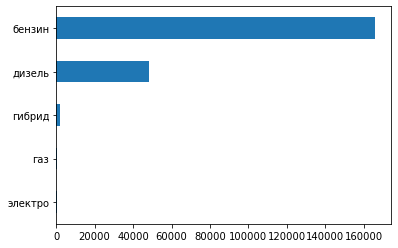

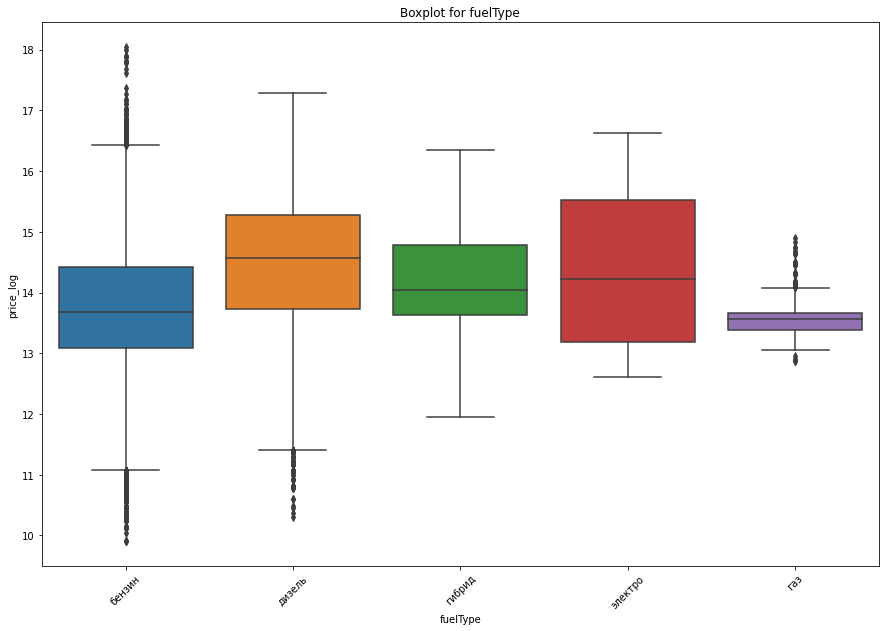

In [814]:
get_hist_box(bined_df, 'fuelType')

Cars with gasoline engine are the most popular, but the most expensive ones have diesel engines.

In [815]:
cat_cols.append('fuelType')

#### mileage

In [816]:
# Check unique values for mileage
bined_df.mileage.unique()

array([  74000.,   60563.,   88000., ..., 1017000.,  548000.,  630000.])

In [817]:
bined_df.mileage.describe()

count    1.864710e+05
mean     1.502645e+05
std      1.025851e+05
min      0.000000e+00
25%      7.600000e+04
50%      1.440000e+05
75%      2.035580e+05
max      1.150000e+06
Name: mileage, dtype: float64

In [918]:
bined_df.mileage.isna().sum()

30128

In [923]:
len(bined_df[bined_df.mileage == 0])

9593

In [928]:
bined_df[bined_df.mileage.isna()]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,train,new_data,price,date_added,price_log,equip_compl,parsing_unixtime
124068,лифтбек,SKODA,белый,1.6,110.0,бензин,NaN,2020.0,NaN,Skoda Rapid II,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK AUTOMATIC 1.6,automatic,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1224000.0,NaN,14.017635,"[cruise-control, asr, tinted-glass, esp, usb, ...",1.634159e+09
124074,лифтбек,SKODA,серый,1.6,110.0,бензин,NaN,2020.0,NaN,Skoda Rapid II,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK AUTOMATIC 1.6,automatic,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1184000.0,NaN,13.984409,"[usb, tyre-pressure, dark-interior, front-seat...",1.634159e+09
124079,лифтбек,SKODA,чёрный,1.4,125.0,бензин,NaN,2020.0,NaN,Skoda Rapid II,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK ROBOT 1.4,robot,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1256000.0,NaN,14.043443,"[cruise-control, glonass, asr, esp, airbag-dri...",1.634159e+09
124080,лифтбек,SKODA,серый,1.4,125.0,бензин,NaN,2020.0,NaN,Skoda Rapid II,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK ROBOT 1.4,robot,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1256000.0,NaN,14.043443,"[cruise-control, asr, glonass, esp, airbag-dri...",1.634159e+09
124084,лифтбек,SKODA,серебристый,1.4,125.0,бензин,NaN,2020.0,NaN,Skoda Rapid II,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",LIFTBACK ROBOT 1.4,robot,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1208000.0,NaN,14.004477,"[cruise-control, asr, tinted-glass, esp, usb, ...",1.634159e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262822,внедорожник,VOLVO,синий,2.0,320.0,бензин,NaN,2019.0,NaN,Volvo XC90 II Рестайлинг,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 2.0,automatic,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,7080000.0,NaN,15.772784,"[multi-wheel, heated-wash-system, airbag-passe...",1.634245e+09
262827,внедорожник,VOLVO,белый,2.0,249.0,бензин,NaN,2019.0,NaN,Volvo XC90 II Рестайлинг,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 2.0,automatic,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5968000.0,NaN,15.601922,"[aux, light-sensor, easy-trunk-opening, electr...",1.634245e+09
262833,внедорожник,VOLVO,серый,2.0,320.0,бензин,NaN,2019.0,NaN,Volvo XC90 II Рестайлинг,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 2.0,automatic,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5832000.0,NaN,15.578871,"[multi-wheel, heated-wash-system, airbag-passe...",1.634245e+09
262835,внедорожник,VOLVO,синий,2.0,320.0,гибрид,NaN,2019.0,NaN,Volvo XC90 II Рестайлинг,5.0,2021.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 2.0,automatic,EUROPEAN,nan,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5728000.0,NaN,15.560877,"[multi-wheel, heated-wash-system, airbag-passe...",1.634245e+09


In [929]:
# Let's fill missing mileage with an average value by productionDate
bined_df.loc[bined_df.mileage.isna(), 'mileage'] = bined_df.groupby('productionDate').mileage.transform('mean')

In [930]:
bined_df.mileage.isna().sum()

0

<AxesSubplot:>

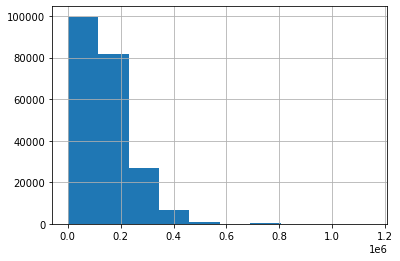

In [931]:
bined_df.mileage.hist()

<AxesSubplot:xlabel='mileage', ylabel='price'>

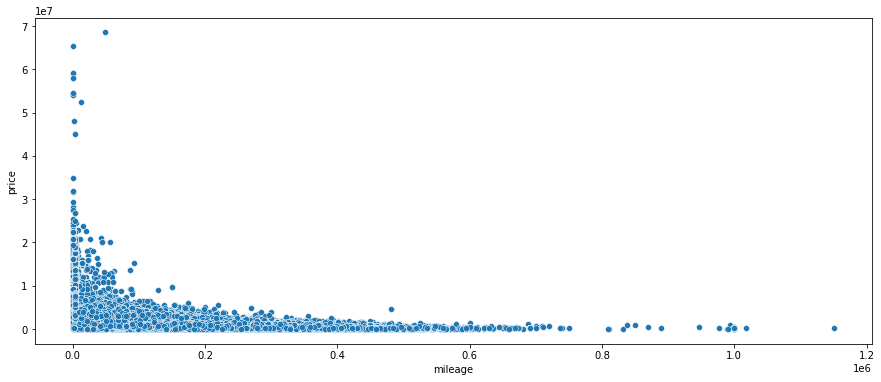

In [932]:
plt.figure(figsize = (15, 6))
sns.scatterplot(data = bined_df[bined_df['train'] == 1], x = 'mileage', y = 'price')

In [936]:
bined_df.mileage.value_counts(bins = 5)

(-1150.001, 230000.0]    182097
(230000.0, 460000.0]      33045
(460000.0, 690000.0]       1166
(690000.0, 920000.0]        235
(920000.0, 1150000.0]        56
Name: mileage, dtype: int64

In [933]:
bined_df[bined_df.mileage > 500000]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,train,new_data,price,date_added,price_log,equip_compl,parsing_unixtime
655,универсал,SKODA,белый,1.2,105.0,бензин,550000.0,2013.0,OCTAVIA,1.2 MT (105 л.с.),5.0,2013.0,1101147381,"{""id"":""10373632"",""displacement"":1197,""engine_t...",WAGON_5_DOORS MECHANICAL 1.2,mechanical,EUROPEAN,3,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,"[asr, esp, airbag-driver, aux, isofix, usb, ai...",1.603228e+09
1912,универсал,SKODA,серебристый,1.9,110.0,дизель,657000.0,2000.0,OCTAVIA,1.9d MT (110 л.с.),5.0,2001.0,1080909484,"{""id"":""4760662"",""displacement"":1896,""engine_ty...",WAGON_5_DOORS MECHANICAL 1.9,mechanical,EUROPEAN,3,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,"[cruise-control, engine-proof, asr, tinted-gla...",1.603228e+09
2643,внедорожник,AUDI,серый,4.2,350.0,бензин,528123.0,2005.0,Q7,4.2 AT (350 л.с.) 4WD,5.0,2008.0,1101123342,"{""id"":""2305498"",""displacement"":4163,""engine_ty...",ALLROAD_5_DOORS AUTOMATIC 4.2,automatic,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,"[cruise-control, asr, tinted-glass, esp, airba...",1.603055e+09
2768,седан,AUDI,чёрный,2.2,230.0,бензин,629000.0,1994.0,S6,2.2 MT (230 л.с.) 4WD,4.0,1996.0,1101215439,"{""id"":""6297117"",""displacement"":2226,""engine_ty...",SEDAN MECHANICAL 2.2,mechanical,EUROPEAN,3,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN,1.603055e+09
3139,седан,AUDI,чёрный,2.3,133.0,бензин,600000.0,1991.0,80,2.3 MT (133 л.с.),4.0,1991.0,1091799378,"{""id"":""7879207"",""displacement"":2309,""engine_ty...",SEDAN MECHANICAL 2.3,mechanical,EUROPEAN,3,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN,1.603055e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262071,универсал,VOLVO,зелёный,2.0,111.0,бензин,519000.0,1988.0,940,Volvo 940,5.0,1992.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",WAGON_5_DOORS MECHANICAL 2.0,mechanical,EUROPEAN,3,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен,1,1,184000.0,11 октября,12.122691,"[front-centre-armrest, alloy-wheel-disks, ptf,...",1.634245e+09
262367,седан,VOLVO,синий,2.4,131.0,дизель,1017000.0,2000.0,S60,Volvo S60 I,4.0,2002.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",SEDAN AUTOMATIC 2.4,automatic,EUROPEAN,3,1 год и 5 месяцев,Дубликат,передний,Левый,Не требует ремонта,Растаможен,1,1,280000.0,4 октября,12.542545,"[cruise-control, tinted-glass, esp, electro-wi...",1.634245e+09
262460,внедорожник,VOLVO,серый,4.4,315.0,бензин,548000.0,2006.0,XC90,Volvo XC90 I Рестайлинг,5.0,2007.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",ALLROAD_5_DOORS AUTOMATIC 4.4,automatic,EUROPEAN,3,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1,1,600000.0,7 марта,13.304685,[],1.634245e+09
262547,универсал,VOLVO,серебристый,2.4,140.0,бензин,536000.0,1991.0,850,Volvo 850,5.0,1996.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",WAGON_5_DOORS MECHANICAL 2.4,mechanical,EUROPEAN,3,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,1,1,136000.0,12 сентября,11.820410,[climate-control-1],1.634245e+09


In [822]:
bined_df[(bined_df.mileage > 500000)&(bined_df.train == 0)]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,train,new_data,price,date_added,price_log,equip_compl
655,универсал,SKODA,белый,1.2,105.0,бензин,550000.0,2013.0,OCTAVIA,1.2 MT (105 л.с.),5.0,1.603229e+09,RUB,2013.0,1101147381,"{""id"":""10373632"",""displacement"":1197,""engine_t...",WAGON_5_DOORS MECHANICAL 1.2,механическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,"[asr, esp, airbag-driver, aux, isofix, usb, ai..."
1912,универсал,SKODA,серебристый,1.9,110.0,дизель,657000.0,2000.0,OCTAVIA,1.9d MT (110 л.с.),5.0,1.603233e+09,RUB,2001.0,1080909484,"{""id"":""4760662"",""displacement"":1896,""engine_ty...",WAGON_5_DOORS MECHANICAL 1.9,механическая,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,"[cruise-control, engine-proof, asr, tinted-gla..."
2643,внедорожник,AUDI,серый,4.2,350.0,бензин,528123.0,2005.0,Q7,4.2 AT (350 л.с.) 4WD,5.0,1.603123e+09,RUB,2008.0,1101123342,"{""id"":""2305498"",""displacement"":4163,""engine_ty...",ALLROAD_5_DOORS AUTOMATIC 4.2,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,"[cruise-control, asr, tinted-glass, esp, airba..."
2768,седан,AUDI,чёрный,2.2,230.0,бензин,629000.0,1994.0,S6,2.2 MT (230 л.с.) 4WD,4.0,1.603123e+09,RUB,1996.0,1101215439,"{""id"":""6297117"",""displacement"":2226,""engine_ty...",SEDAN MECHANICAL 2.2,механическая,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN
3139,седан,AUDI,чёрный,2.3,133.0,бензин,600000.0,1991.0,80,2.3 MT (133 л.с.),4.0,1.603125e+09,RUB,1991.0,1091799378,"{""id"":""7879207"",""displacement"":2309,""engine_ty...",SEDAN MECHANICAL 2.3,механическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33916,универсал,VOLKSWAGEN,серебристый,1.9,90.0,дизель,500400.0,1997.0,GOLF,1.9d MT (90 л.с.),5.0,1.603656e+09,RUB,1999.0,1101369035,"{""id"":""20399410"",""displacement"":1896,""engine_t...",WAGON_5_DOORS MECHANICAL 1.9,механическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN
33995,седан,VOLKSWAGEN,синий,1.8,90.0,бензин,539000.0,1988.0,PASSAT,1.8 MT (90 л.с.),4.0,1.603661e+09,RUB,1989.0,1101368206,"{""id"":""21279300"",""displacement"":1781,""engine_t...",SEDAN MECHANICAL 1.8,механическая,EUROPEAN,3 или более,5 лет и 1 месяц,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,[audiosystem-cd]
34017,универсал,VOLKSWAGEN,чёрный,1.6,72.0,бензин,800000.0,1988.0,PASSAT,1.6 MT (72 л.с.),5.0,1.603662e+09,RUB,1989.0,1101220107,"{""id"":""6391682"",""displacement"":1595,""engine_ty...",WAGON_5_DOORS MECHANICAL 1.6,механическая,EUROPEAN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN
34267,купе,HONDA,серебристый,1.6,105.0,бензин,999999.0,1995.0,CIVIC,1.6 MT (105 л.с.),2.0,1.603675e+09,RUB,1997.0,1091449512,"{""id"":""5110069"",""displacement"":1590,""engine_ty...",COUPE MECHANICAL 1.6,механическая,JAPANESE,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN


In [934]:
bined_df.loc[bined_df.mileage == bined_df.mileage.max()]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,train,new_data,price,date_added,price_log,equip_compl,parsing_unixtime
159765,хэтчбек,HONDA,белый,1.3,91.0,бензин,1150000.0,1996.0,Logo,Honda Logo,5.0,2001.0,0,"{'sale-data-attributes': {'asciiCat': 'cars', ...",HATCHBACK_5_DOORS MECHANICAL 1.3,mechanical,JAPANESE,3,NaN,Оригинал,передний,Правый,Не требует ремонта,Растаможен,1,1,152000.0,25 марта 2020,11.931636,[],1.634245e+09


In [935]:
outliers(bined_df, 'mileage')

For mileage IQR: 163000.0, 
 Outliers boundaries: [-214500.0, 437500.0].
Total 2202 outliers
 0 left outliers 
 2202 right outliers 



We can see here that the mean value of mileage is 150000 and the biggest percent of cars has not more than 230000 km mileage. Also, the less the mileage, the higher the price.

#### modelDate

In [825]:
# Check the unique values for modelDate
bined_df.modelDate.unique()

array([2013., 2017., 2008., 2009., 2016., 2012., 2015., 2010., 2006.,
       2000., 2007., 1994., 2004., 1999., 2005., 1976., 2001., 1969.,
       1996., 1998., 1989., 1934., 2014., 2011., 2018., 1986., 1997.,
       1990., 2019., 2002., 1991., 1987., 1980., 1982., 1938., 1988.,
       2003., 1983., 1978., 1979., 1984., 1992., 1995., 1993., 1985.,
       1974., 1966., 1977., 1981., 1972., 1968., 1975., 1949., 1937.,
       1936., 1973., 1959., 1958., 2020., 1965., 1971., 1904., 1963.,
       1955., 1951., 1960., 1950., 1961., 1957., 2021.])

In [826]:
bined_df.modelDate.describe()

count    216599.000000
mean       2010.046441
std           7.567827
min        1904.000000
25%        2006.000000
50%        2011.000000
75%        2016.000000
max        2021.000000
Name: modelDate, dtype: float64

<AxesSubplot:>

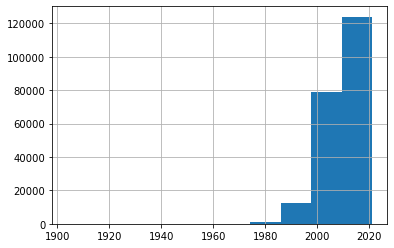

In [827]:
bined_df.modelDate.hist()

<AxesSubplot:xlabel='modelDate', ylabel='price'>

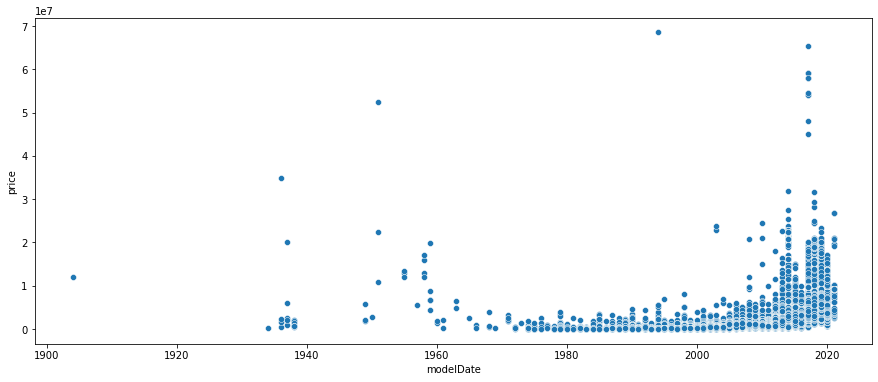

In [828]:
plt.figure(figsize = (15, 6))
sns.scatterplot(data = bined_df[bined_df['train'] == 1], x = 'modelDate', y = 'price')

In [829]:
outliers(bined_df, 'modelDate')

For modelDate IQR: 10.0, 
 Outliers boundaries: [1991.0, 2031.0].
Total 4016 outliers
 4016 left outliers 
 0 right outliers 



#### model_name

In [830]:
# Check unique values
bined_df.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR', 'Q5', 'R8', 'Q7', 'Q3', 'A4',
       'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6', 'ALLROAD', 'TT', 'S5', 'S8',
       'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3', 'A4_ALLROAD', 'Q8', '100',
       'SQ5', 'S4', 'TT_RS', 'RS4', 'S7', 'RS5', '90', 'COUPE', 'A2',
       'TTS', '920', 'S3', '200', 'V8', 'E_TRON', 'CR_V', 'ACCORD',
       'PILOT', 'CIVIC', 'ODYSSEY', 'STREAM', 'CROSSTOUR', 'ELYSION',
       'ELEMENT', 'RIDGELINE', 'FIT', 'HR_V', 'SHUTTLE', 'FREED',
       'ODYSSEY_NA', 'JAZZ', 'Z', 'CIVIC_FERIO', 'S2000', 'CR_Z',
       'LEGEND', 'STEPWAGON', 'CIVIC_TYPE_R', 'FR_V', 'CR_X', 'PRELUDE',
       'MOBILIO_SPIKE', 'N_BOX', 'ZEST', 'INTEGRA', 'INSPIRE', 'VEZEL',
       'N_WGN', 'ASCOT', 'LOGO', 'ACTY', 'CONCERTO', 'AVANCIER', 'SABER',
       'MOBILIO', 'CROSSROAD', 'INSIGHT', 'TORNEO', 'AIRWAVE', 'DOMANI',
       'RAFA

In [831]:
len(bined_df.model_name.unique())

974

#### name

In [832]:
# Check unique values
bined_df.name.unique()

array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
       'DSG 1.8 AMT (152 л.с.)', ..., 'Volvo 850 R', 'Volvo S60 R I',
       'Volvo Laplander TGB 1314'], dtype=object)

In [833]:
len(bined_df.name.unique())

5464

#### numberOfDoors

In [834]:
# Check the unique values
bined_df.numberOfDoors.unique()

array([5., 4., 2., 3., 0.])

In [835]:
bined_df[bined_df.numberOfDoors == 0]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,owners,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,train,new_data,price,date_added,price_log,equip_compl
16944,кабриолет,MERCEDES,белый,5.3,32.0,бензин,48000.0,1904.0,SIMPLEX,5.3 MT (32 л.с.),0.0,1.603246e+09,RUB,1904.0,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,0,0,NaN,NaN,NaN,NaN
122751,кабриолет,MERCEDES,белый,5.3,32.0,бензин,48000.0,1904.0,SIMPLEX,5.3 MT (32 л.с.),0.0,1.599599e+09,NaN,1904.0,0,NaN,CABRIO MECHANICAL 5.3,MECHANICAL,EUROPEAN,1.0,"{'year': 2014, 'month': 2}",ORIGINAL,задний,RIGHT,NaN,True,1,0,12000000.0,2019-11-20T14:14:11Z,16.300417,NaN


This model literally has no doors.

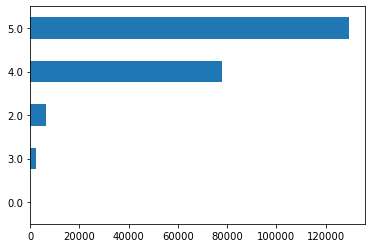

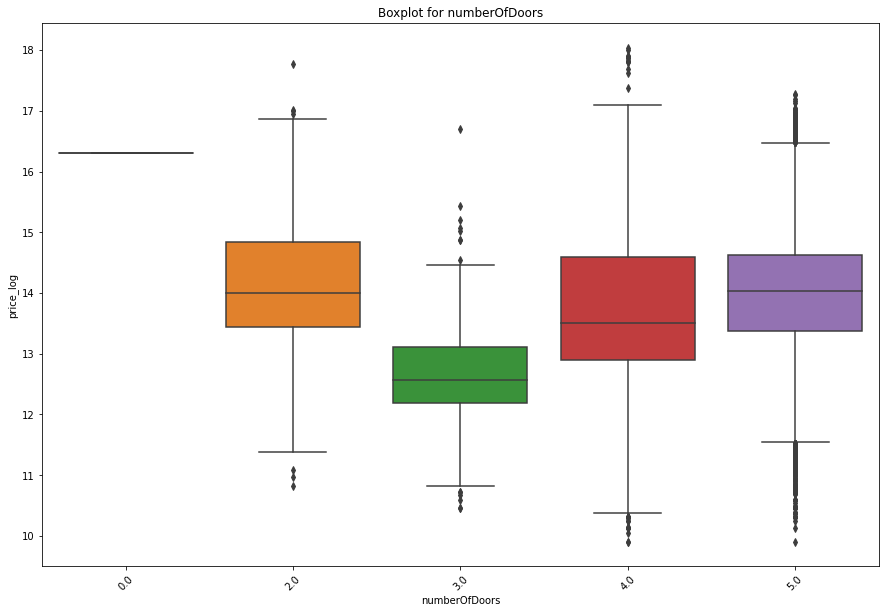

In [836]:
get_hist_box(bined_df, 'numberOfDoors')

Cars with 5 and 4 doors are the most popular with almost equal average price. Cars with 3 doors are the cheapest.

In [837]:
cat_cols.append('numberOfDoors')

#### parsing_unixtime

In [838]:
# get only year, month, day from the parsing_unixtime column as we have only them for train_ready df
bined_df['parsing_unixtime_1'] = bined_df.parsing_unixtime.apply(lambda x: \
                                 datetime.timestamp(datetime.strptime(datetime.fromtimestamp(x).\
                                                                      strftime('%Y-%m-%d'), '%Y-%m-%d')))
bined_df.drop('parsing_unixtime', inplace = True, axis=1)
bined_df.rename(columns= {'parsing_unixtime_1':'parsing_unixtime'}, inplace=True)

#### priceCurrency

In [839]:
# Check the unique values
bined_df.priceCurrency.unique()

array(['RUB', nan], dtype=object)

In [840]:
bined_df.priceCurrency.value_counts()

RUB    169165
Name: priceCurrency, dtype: int64

In [841]:
bined_df.priceCurrency.isna().sum()

47434

In this column we can see that currency is either RUB, or nan. As it's Russuan car market let's suggest that all prices are in Russian roubles and drop this column.

In [842]:
bined_df.drop(['priceCurrency'], axis = 1, inplace = True)

#### productionDate

In [843]:
# Check unique values
bined_df.productionDate.unique()

array([2014., 2017., 2012., 2011., 2019., 2018., 2010., 2020., 2016.,
       2013., 2006., 2007., 2015., 2005., 2008., 2009., 1997., 2004.,
       2002., 1987., 2003., 2001., 1976., 2000., 1998., 1995., 1999.,
       1993., 1939., 1996., 1984., 1990., 1991., 1992., 1989., 1982.,
       1985., 1994., 1938., 1981., 1988., 1983., 1980., 1986., 1978.,
       1970., 1979., 1977., 1972., 1975., 1969., 1950., 1953., 1949.,
       1937., 1959., 1968., 1936., 1904., 1974., 1967., 1961., 1960.,
       1965., 1963., 1957., 1952., 1973., 1948., 1954., 1964., 1966.,
       2021.])

In [844]:
bined_df.productionDate.describe()

count    216599.000000
mean       2012.178057
std           7.326995
min        1904.000000
25%        2008.000000
50%        2013.000000
75%        2018.000000
max        2021.000000
Name: productionDate, dtype: float64

<AxesSubplot:>

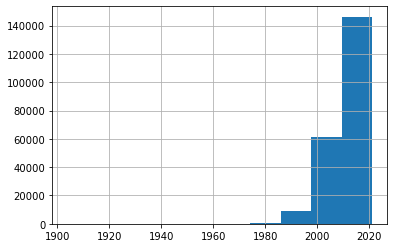

In [845]:
bined_df.productionDate.hist()

<AxesSubplot:xlabel='productionDate', ylabel='price'>

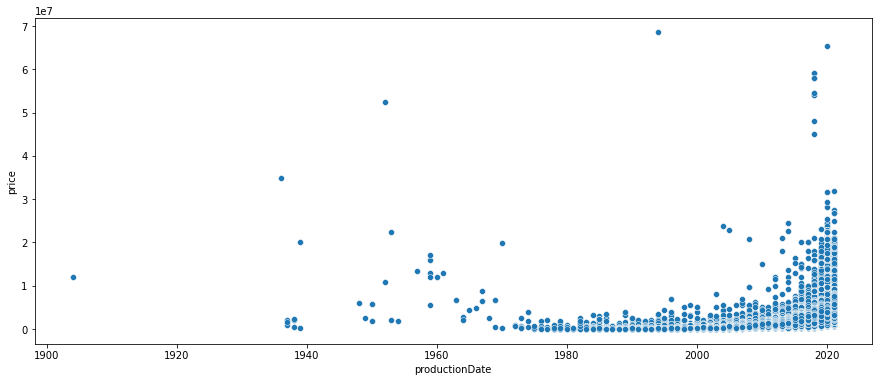

In [846]:
plt.figure(figsize = (15, 6))
sns.scatterplot(data = bined_df[bined_df['train'] == 1], x = 'productionDate', y = 'price')

In [847]:
outliers(bined_df, 'modelDate')

For modelDate IQR: 10.0, 
 Outliers boundaries: [1991.0, 2031.0].
Total 4016 outliers
 4016 left outliers 
 0 right outliers 



We don't have any cared produced later than 2021. The picture resembles modelDate a lot. Probably there's strong correlation, we'll check it later.

#### super_gen

In [848]:
bined_df.super_gen[0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [849]:
bined_df.super_gen.isna().sum()

47434

***!!! Need to decide what to do with this column***

#### vehicleConfiguration

In [850]:
bined_df.vehicleConfiguration

0                     LIFTBACK ROBOT 1.2
1                LIFTBACK MECHANICAL 1.6
2                     LIFTBACK ROBOT 1.8
3                 LIFTBACK AUTOMATIC 1.6
4                 LIFTBACK AUTOMATIC 1.8
                       ...              
262834               SEDAN AUTOMATIC 2.3
262835     ALLROAD_5_DOORS AUTOMATIC 2.0
262836    ALLROAD_5_DOORS MECHANICAL 2.5
262837       WAGON_5_DOORS AUTOMATIC 3.2
262838     ALLROAD_5_DOORS AUTOMATIC 2.0
Name: vehicleConfiguration, Length: 216599, dtype: object

In [851]:
bined_df.vehicleConfiguration.isna().sum()

0

#### vehicleTransmission

In [852]:
# Check the unique values
bined_df.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       'MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR'], dtype=object)

In [853]:
bined_df.vehicleTransmission.isna().sum()

0

In [854]:
bined_df.vehicleTransmission = bined_df.vehicleTransmission.apply(
    lambda x: str(x).lower() if x else 0)

In [855]:
bined_df.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       'mechanical', 'automatic', 'robot', 'variator'], dtype=object)

In [856]:
bined_df.vehicleTransmission = bined_df.vehicleTransmission.apply(
    lambda x: 'mechanical' if x == 'механическая' else 'automatic' if x == 'автоматическая' 
    else 'robot' if x == 'роботизированная' else 'variator' if x == 'вариатор' else x)

In [857]:
bined_df.vehicleTransmission.unique()

array(['robot', 'mechanical', 'automatic', 'variator'], dtype=object)

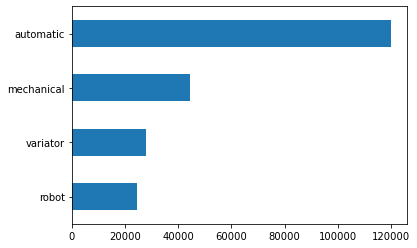

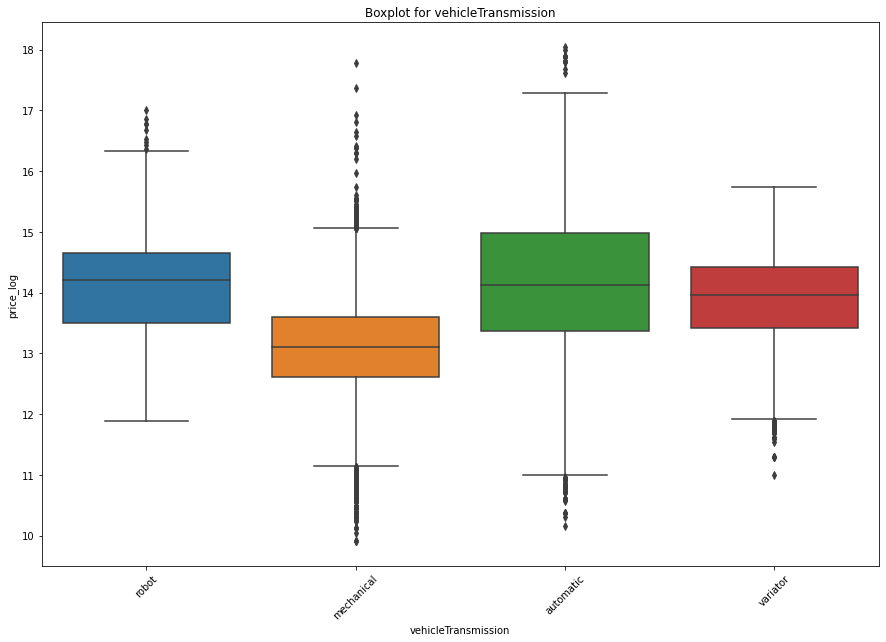

In [858]:
get_hist_box(bined_df, 'vehicleTransmission')

In [859]:
bined_df.vehicleTransmission.value_counts()

automatic     119763
mechanical     44422
variator       27745
robot          24669
Name: vehicleTransmission, dtype: int64

Automatic transmission is the most popular but robot has the highest price.

In [860]:
cat_cols.append('vehicleTransmission')

In [861]:
cat_cols

['bodyType',
 'brand',
 'color',
 'fuelType',
 'numberOfDoors',
 'vehicleTransmission']

#### vendor

In [862]:
# Check the unique values 
bined_df.vendor.unique()

array(['EUROPEAN', 'JAPANESE', nan], dtype=object)

In [863]:
bined_df.vendor.isna().sum()

2182

In [864]:
bined_df['vendor'] = bined_df.brand.map(ven_dict)
bined_df.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

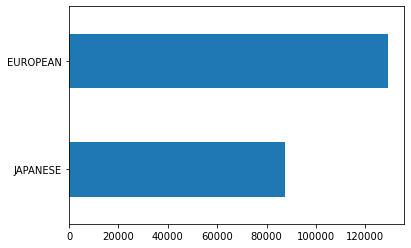

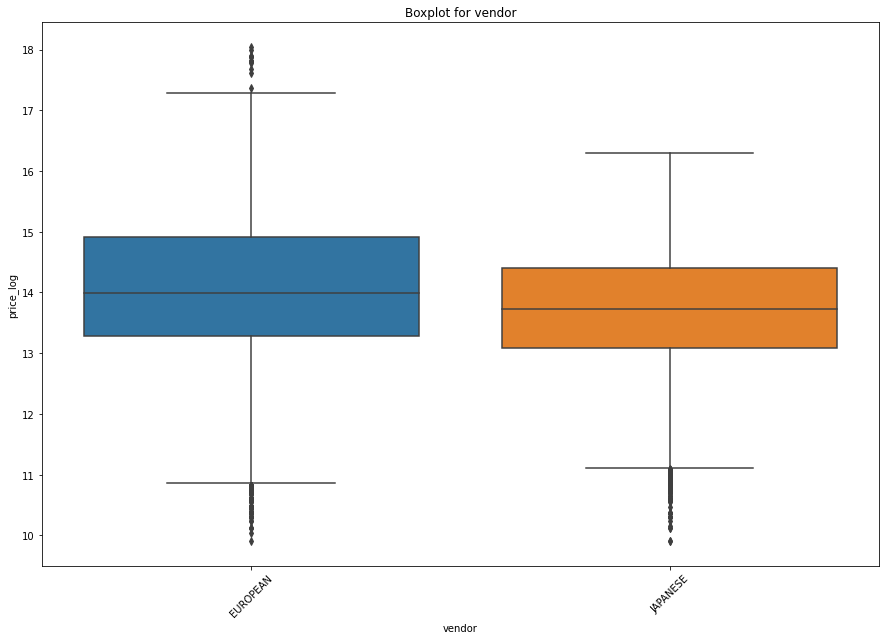

In [865]:
get_hist_box(bined_df, 'vendor')

In [866]:
bined_df.vendor.value_counts(normalize = True)

EUROPEAN    0.596249
JAPANESE    0.403751
Name: vendor, dtype: float64

In [867]:
bin_cols.append('vendor')

#### owners

In [868]:
# Check the unique values 
bined_df.owners.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', 3.0, 1.0, 2.0,
       nan, '1 владелец', '2 владельца'], dtype=object)

In [869]:
bined_df.owners.isna().sum()

39721

In [870]:
bined_df['owners'] = bined_df['owners'].astype(str)
bined_df['owners'] = bined_df.owners.apply(lambda x: x if x == 'nan' else x[0])

In [876]:
bined_df.owners.unique()

array(['3', '1', '2', 'nan'], dtype=object)

In [875]:
bined_df[bined_df.owners == 'nan'].mileage.unique()

array([ 0., nan])

In [895]:
bined_df[bined_df.owners == 'nan'].mileage.value_counts()

0.0    9593
Name: mileage, dtype: int64

In [910]:
# Let's suggest that these are brand new cars so we'll set owners value to 0
bined_df.loc[(bined_df.owners == 'nan') & (bined_df.mileage == 0.0), 'owners'] = 0

In [958]:
bined_df.owners.unique()

array([ 3.,  1.,  2.,  0., nan])

In [913]:
bined_df.owners.isna().sum()

0

In [917]:
len(bined_df[bined_df.owners == 'nan'])

30128

In [959]:
type(bined_df.owners[0])

numpy.float64

In [957]:
# Convert to float values
bined_df.owners = bined_df.owners.apply(lambda x: float(x) if x else x)

In [962]:
bined_df.groupby('productionDate').owners.median()

productionDate
1904.0    1.0
1936.0    1.0
1937.0    2.0
1938.0    2.0
1939.0    3.0
         ... 
2017.0    1.0
2018.0    1.0
2019.0    1.0
2020.0    0.0
2021.0    1.0
Name: owners, Length: 73, dtype: float64

In [965]:
# Let's fill missing owners with an average value by productionDate
bined_df.loc[bined_df.owners.isna(), 'owners'] = bined_df.groupby('productionDate').owners.transform('median')

In [966]:
bined_df.owners.isna().sum()

0

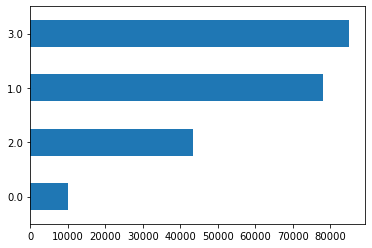

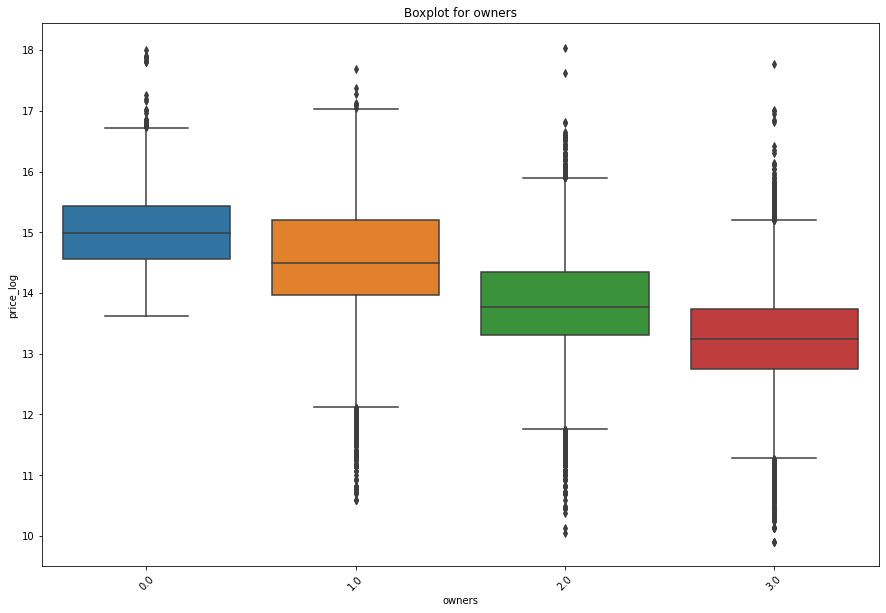

In [967]:
get_hist_box(bined_df, 'owners')

#### ownership

#### vehicleLicense

#### driving_gear

#### steering_wheel

In [456]:
# Check the unique values 
bined_df.steering_wheel.unique()

array(['Левый', 'Правый', 'LEFT', 'RIGHT', nan], dtype=object)

In [459]:
bined_df.steering_wheel.value_counts()

Левый     132676
LEFT       45907
Правый      6361
RIGHT       1527
Name: steering_wheel, dtype: int64

In [461]:
bined_df.steering_wheel.isna().sum()

30128

In [464]:
bined_df.steering_wheel = bined_df.steering_wheel.apply(
    lambda x: str(x).lower() if x else 0)

In [465]:
bined_df.steering_wheel.value_counts()

левый     132676
left       45907
nan        30128
правый      6361
right       1527
Name: steering_wheel, dtype: int64

In [469]:
bined_df.steering_wheel = bined_df.steering_wheel.apply(
    lambda x: 'left' if x == 'левый' else 'right' if x == 'правый' else x)

In [537]:
bined_df.steering_wheel.value_counts()

left     178583
nan       30128
right      7888
Name: steering_wheel, dtype: int64

In [471]:
right_wheel_models = bined_df[bined_df.steering_wheel == 'right'].groupby(['brand', 'model_name']).bodyType.count() 
right_wheel_models = right_wheel_models.reset_index().sort_values('bodyType', ascending=False)
right_wheel_dict = right_wheel_models[right_wheel_models.bodyType > 1].groupby('brand').agg({'model_name': lambda x: x.tolist()}).to_dict()['model_name']

In [472]:
right_wheel_dict

{'BMW': ['2GRANDTOURER'],
 'HONDA': ['Freed',
  'Fit',
  'Stepwgn',
  'Odyssey',
  'CR-V',
  'Accord',
  'Civic Ferio',
  'Shuttle',
  'HR-V',
  'Civic',
  'Stream',
  'Vezel',
  'Integra',
  'Prelude',
  'N-WGN',
  'FIT',
  'STEPWAGON',
  'Fit Shuttle',
  'Domani',
  'Inspire',
  'Capa',
  'Rafaga',
  'STREAM',
  'ACCORD',
  'Torneo',
  'HR_V',
  'Orthia',
  'FREED',
  'CR_V',
  'Airwave',
  'Insight',
  'Logo',
  'N-BOX',
  'Avancier',
  'N_BOX',
  'Jade',
  'Mobilio',
  'PRELUDE',
  'CIVIC_FERIO',
  'Crossroad',
  'CIVIC',
  'Partner',
  'N_WGN',
  'ODYSSEY',
  'INTEGRA',
  'Ascot',
  'Elysion',
  'ORTHIA',
  'AVANCIER',
  'INSPIRE',
  'CR-Z',
  'MOBILIO',
  'Acty',
  'Fit Aria',
  'Mobilio Spike',
  'Life',
  'SHUTTLE',
  'Ascot Innova',
  'DOMANI',
  'Saber',
  'Grace',
  'S-MX',
  'ACTY',
  'AIRWAVE',
  'SABER',
  'Integra SJ',
  'LOGO',
  'Zest',
  'Vamos',
  'VEZEL',
  'RAFAGA',
  'S660',
  'Z',
  'Element',
  'ASCOT',
  'Concerto',
  'PARTNER',
  'CROSSROAD',
  'MOBILIO_SPIKE'

In [473]:
bined_df.loc[bined_df.steering_wheel.isna(), 'steering_wheel'] = bined_df[bined_df.steering_wheel.isna()].apply(
    lambda row: fill_steering_wheel(row.brand, row.model_name, right_wheel_dict), axis=1)

In [474]:
bined_df.steering_wheel.value_counts()

left     178583
nan       30128
right      7888
Name: steering_wheel, dtype: int64

In [475]:
bin_cols.append('steering_wheel')

#### condition

In [397]:
# Check the unique values
bined_df.condition.unique()

array(['Не требует ремонта', nan], dtype=object)

In [398]:
bined_df.condition.value_counts()

Не требует ремонта    139036
Name: condition, dtype: int64

Obviously we can't fill in missing values here, so this column will be dropped.

In [399]:
bined_df.drop(['condition'], axis = 1, inplace = True)

#### customs

In [401]:
# Check the unique values
bined_df.customs.unique()

array(['Растаможен', True, nan], dtype=object)

In [403]:
bined_df.customs.value_counts()

Растаможен    139035
True           47434
Name: customs, dtype: int64

Officialy in Russia you can't buy a car without customs declaration, so this column will be dropped.

In [404]:
bined_df.drop(['customs'], axis = 1, inplace = True)

#### date_added

In [544]:
bined_df.date_added

0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
             ...     
262834    29 сентября
262835            NaN
262836     18 августа
262837        19 июля
262838            NaN
Name: date_added, Length: 216599, dtype: object

In [545]:
bined_df.date_added.isna().sum()

64814

Seems that we can't extract anything useful here, so just drop it.

In [ ]:
bined_df.drop(['date_added'], axis = 1, inplace = True)

In [ ]:
num_cols = [x for x in bined_df.select_dtypes(include=np.number).columns.tolist() \
            if x not in ['sell_id', 'train','new_data']]

In [405]:
bined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216599 entries, 0 to 262838
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              216599 non-null  object 
 1   brand                 216599 non-null  object 
 2   color                 216586 non-null  object 
 3   engineDisplacement    216599 non-null  float64
 4   enginePower           216599 non-null  object 
 5   fuelType              216599 non-null  object 
 6   mileage               186471 non-null  float64
 7   modelDate             216599 non-null  float64
 8   model_name            186471 non-null  object 
 9   name                  216599 non-null  object 
 10  numberOfDoors         216599 non-null  float64
 11  productionDate        216599 non-null  float64
 12  sell_id               216599 non-null  int64  
 13  super_gen             169165 non-null  object 
 14  vehicleConfiguration  216599 non-null  object 
 15  

### Feature importance and correlation

In [ ]:
# Numeric features importance
imp_num = Series(f_classif(bined_df[num_cols], bined_df['price'])[
                 0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Numeric features importance')

In [ ]:
# Numeric features correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(bined_df[num_cols + ['price']].corr(), annot=True,
            fmt='.1g', vmin=-1, vmax=1, center=0, cmap='RdBu')

In [ ]:
# Categoriсal and binary features importance
imp_cat = Series(mutual_info_classif(bined_df[bin_cols + cat_cols], bined_df['price'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [ ]:
# Categoriсal and binary features correlation
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(bined_df[cat_cols + bin_cols].corr(), annot=True,
            fmt='.1g', vmin=-1, vmax=1, center=0, cmap='RdBu')